# Non-ideal gas models in Cantera

In this example, we will demonstrate Cantera's ability to handle non-ideal gas equations of state.  This particular example will use a multi-component Redlich-Kwong Equation of state:
$$p = \frac{RT}{v - b} - \frac{a}{v\sqrt{T}\left(v+b\right)}$$
and will compare results to an ideal gas approximation:
$$pv = RT$$
We will compare various properties of a mixture CO$_2$, H$_2$O, H$_2$, and CO.

First, import the necessary python modules:

In [1]:
import cantera as ct
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.autolayout'] = True

## Constructing a phase diagram
For the first example, we will construct the phase diagram in the saturated liquid-vapor region for a mixture that is 99% CO$_2$, 1% H$_2$ (by mole).

First identify the range of temperature and pressure values.  Store the number of pressures and temperatures, and initialize the matrix of specific volume (m$^3$/kg) values.

In [2]:
Temps = np.array(range(282,380,2));
P_crit = 7.38937e6
press = P_crit*np.array([0.5,0.75,0.9,1.0,1.1,1.25,1.54,1.75,2,5,10]);
npress = press.size
ntemp = Temps.size
v_spec = np.zeros((npress,ntemp))

### First, construct the "phase diagram" using an ideal gas object.  

Start by loading the gas object from the input file:

In [3]:
Ideal_gas = ct.Solution('input-files/non-ideal-models/co2_RK_example.cti','carbondioxide_ideal')

/var/folders/d4/mt_nqf_x42vgxs9t9mw1l59m0000gn/T/ipykernel_66427/2545598228.py:1: DeprecationWarning: XML_Node::build: 
The CTI and XML input file formats are deprecated and will be removed in
Cantera 3.0. Use 'cti2yaml.py' or 'ctml2yaml.py' to convert CTI or XML input
files to the YAML format. See https://cantera.org/tutorials/legacy2yaml.html
for more information.
  Ideal_gas = ct.Solution('input-files/non-ideal-models/co2_RK_example.cti','carbondioxide_ideal')


Now loop over the temperatures and pressures, and store the specific volume at each set of conditions:

In [4]:
for i, P in enumerate(press):
    for j, T in enumerate(Temps):
        Ideal_gas.TP = T, P
        v_spec[i,j] = 1/Ideal_gas.density

We plot the results, seeing that (as expected) the ideal gas model is incapable of predicting phase change.

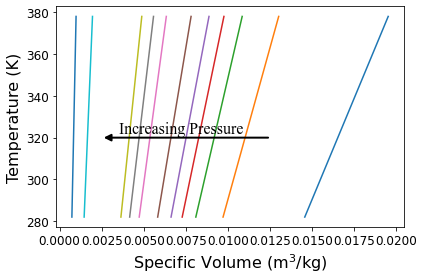

In [5]:
plt.figure()
plt.plot(np.transpose(v_spec),Temps)#,'D')
plt.xlabel('Specific Volume (m$^3$/kg)')
plt.ylabel('Temperature (K)')
ax = plt.gca()
ax.annotate("",xy=(0.0025,320), xytext=(0.0125,320),arrowprops=dict(arrowstyle="-|>",color='k',linewidth=2.0),fontsize=14,)
plt.annotate('Increasing Pressure', xy=(0.0025,320), xytext=(0.0035, 322), family='Times New Roman',fontsize=16);

plt.show()

### Repeat the process for a non-ideal Redlich-Kwong equation of state:

In [6]:
RK_gas = ct.Solution('input-files/non-ideal-models/co2_RK_example.cti','carbondioxide')

In [7]:
for i, P in enumerate(press):
    for j, T in enumerate(Temps):
        RK_gas.TP = T, P
        v_spec[i,j] = 1/RK_gas.density

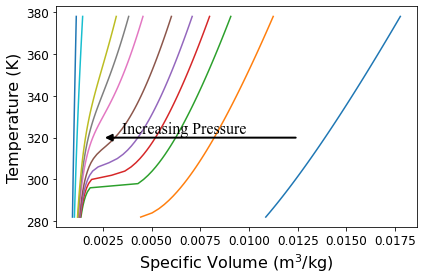

In [8]:
plt.figure()
plt.plot(np.transpose(v_spec),Temps)#,'D')
plt.xlabel('Specific Volume (m$^3$/kg)')
plt.ylabel('Temperature (K)')
ax = plt.gca()
ax.annotate("",xy=(0.0025,320), xytext=(0.0125,320),arrowprops=dict(arrowstyle="-|>",color='k',linewidth=2.0),fontsize=14,)
plt.annotate('Increasing Pressure', xy=(0.0025,320), xytext=(0.0035, 322), family='Times New Roman',fontsize=16);

plt.show()

#### Now we see the expected behavior, with phase change below the critical point, and a continuous change of properties for the supercritical fluid.

## Calculating chemical reaction rates.

In this example, we will compare chemical rates for the ideal and real gas models.  One wonderful thing about Cantera, as seen above, is that once the phase is created, the procedure for these calculations is independent of the EoS.

### Application 1: Water-gas shift reaction
For the second example, we will compare reaction rates of progress for the water-gas shift reaction:

$${\rm H}_2{\rm O} + {\rm CO} \leftrightarrow {\rm CO}_2 + {\rm H}_2$$

These will be calculated for a zero-D reactor.  Simulations will have an initial condition of $T =$ 800 K, and a composition of 50% CO$_2$, 50% H$_2$.  Start at low pressure (1 atmosphere).  Load the initial conditions to each gas object, and create the reactor and reactor network for each.  Initialize lists to store the H$_2$ mole fraction and the simulation time:

In [9]:
RK_gas.TPX = 800, 101325, {'CO2':0.5, 'H2':0.5}
Ideal_gas.TPX = 800, 101325, {'CO2':0.5, 'H2':0.5}

r_RK = ct.Reactor(contents=RK_gas,name='RK reactor')
reactorNetwork_RK = ct.ReactorNet([r_RK])

r_IG = ct.IdealGasReactor(contents=Ideal_gas,name='IG reactor')
reactorNetwork_IG = ct.ReactorNet([r_IG])

X_RK = list()
X_IG = list()

times_RK = list()
times_IG = list()

Integrate the reactors:

In [10]:
t_RK = 0
t_IG = 0

while(t_RK < 100):
    t_RK = reactorNetwork_RK.step()   
    times_RK.append(t_RK)
    X_RK.append(RK_gas.X[2])
while(t_IG < 100):
    t_IG = reactorNetwork_IG.step() 
    times_IG.append(t_IG)
    X_IG.append(Ideal_gas.X[2])

Plotting the results, we see that the two equations of state agree exactly at low pressure:

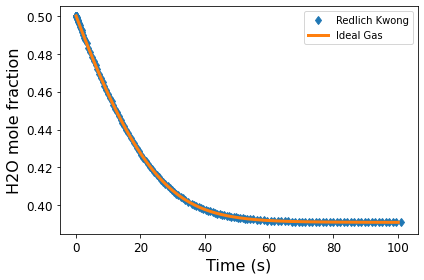

In [11]:
plt.figure()
plt.plot(times_RK,X_RK,'d')
plt.plot(times_IG,X_IG,linewidth=3.0)
plt.xlabel('Time (s)')
plt.ylabel('H2O mole fraction')
plt.legend(['Redlich Kwong', 'Ideal Gas'])
plt.ylim((0.385,0.505))
plt.show()

Now repeat the process at a very high pressure (100 atmospheres).

In [12]:
RK_gas.TPX = 800, 100*101325, {'CO2':0.5, 'H2':0.5}
Ideal_gas.TPX = 800, 100*101325, {'CO2':0.5, 'H2':0.5}

r_RK = ct.Reactor(contents=RK_gas,name='RK reactor')
reactorNetwork_RK = ct.ReactorNet([r_RK])

r_IG = ct.IdealGasReactor(contents=Ideal_gas,name='IG reactor')
reactorNetwork_IG = ct.ReactorNet([r_IG])


X_RK = list()
X_IG = list()

times_RK = list()
times_IG = list()

In [13]:
t_RK = 0
t_IG = 0
while(t_RK < 50):
    t_RK = reactorNetwork_RK.step()   
    times_RK.append(t_RK)
    X_RK.append(RK_gas.X[2])
while(t_IG < 50):
    t_IG = reactorNetwork_IG.step() 
    times_IG.append(t_IG)
    X_IG.append(Ideal_gas.X[2])

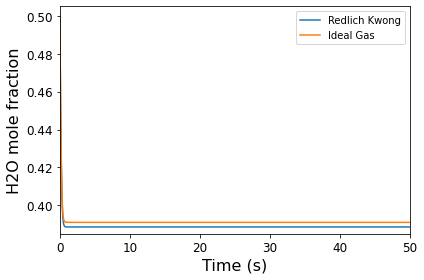

In [14]:
plt.figure()
plt.plot(times_RK,X_RK)
plt.plot(times_IG,X_IG)
plt.xlabel('Time (s)')
plt.ylabel('H2O mole fraction')
plt.legend(['Redlich Kwong', 'Ideal Gas'])
plt.ylim((0.385,0.505))
plt.xlim((0,50))
plt.show()

While the difference between the two models is rather small, there are a number of other situations where non-idealities will have a more significant impact.

# Non-Ideal Shock Tube Example
## Ignition delay time computations in a high-pressure reflected shock tube reactor
 
In this example we will illustrate how to setup and use a constant volume, adiabatic reactor to simulate reflected shock tube experiments. This reactor will then be used to compute the ignition delay of a gas at any temperature and pressure.  The example very explicitly follows the form set in batch_reactor_ignition_delay_NTC.pynb, which does very similar calculations, but with an IdealGasReactor.  All credit is due to the developer of that example.  This example generalizes that work to use a Reactor with no pre-assumed EoS.  One can also run ideal gas phases through this simulation, simply by specifying a cti file with that thermodynamic EoS.

Other than the typical Cantera dependencies, plotting functions require that you have matplotlib installed, and data storing and analysis requires pandas. See https://matplotlib.org/ and http://pandas.pydata.org/index.html, respectively, for additional info.
 
The example here demonstrates the calculations carried out by G. Kogekar, et al., "Impact of non-ideal behavior on ignition delay and chemical kinetics in high-pressure shock tube reactors," Combust. Flame., 2017.

The reflected shock tube reactor is modeled as a constant-volume, adiabatic reactor.  The heat transfer and the work rates are therefore both zero.  With no mass inlets or exits, the 1st law energy balance reduces to:

\begin{equation*}
\frac{dU}{dt} = \dot{Q} - \dot{W} = 0.
\end{equation*}
 
Because of the constant-mass and constant-volume assumptions, the density is also therefore constant:

\begin{equation*}
\frac{d\rho}{dt} = 0.
\end{equation*}

Along with the evolving gas composition, then, the thermodynamic state of the gas is defined by the initial total internal energy $U = mu = m\sum_k\left(Y_ku_k\right)$, where $u_k$ and $Y_k$ are the specific internal energy (kJ/kg) and mass fraction of species $k$, respectively. 

The species mass fractions evolve according to the nety chemical production rates due to homogeneous gas-phase reactions:

\begin{equation*}
\frac{dY_k}{dt} = \frac{W_k}{\rho}\dot{\omega}_k,
\end{equation*}

where $W_k$ is the molecular weight of species $k$ $\left({\rm kg}\,{\rm kmol}^{-3}\right)$, $\rho$ is the (constant) gas-phase density $\left({\rm kg}\,{\rm m^{-3}}\right)$, and $\dot{\omega}_k$ is the net production rate of species $k$ $\left({\rm kmol}\,{\rm m^{-3}}\,{\rm s^{-1}}\right)$.

In [15]:
import pandas as pd

import time

print('Runnning Cantera version: ' + ct.__version__)

Runnning Cantera version: 2.6.0


### Define the gas

In this example we will choose a stoichiometric mixture of n-dodecane and air as the gas. For a representative kinetic model, we use that developed by Wang, Ra, Jia, and Reitz (https://www.erc.wisc.edu/chem_mech/nC12-PAH_mech.zip) by [H.Wang, Y.Ra, M.Jia, R.Reitz, Development of a reduced n-dodecane-PAH mechanism and its application for n-dodecane soot predictions, $Fuel$ 136 (2014) 25–36].

To fun a different model or use a different EoS, simply replace this cti file with a different mechanism file.

In [16]:
gas = ct.Solution('input-files/non-ideal-models/WangMechanismRK.cti')

### Define reactor conditions : temperature, pressure, fuel, stoichiometry

In [17]:
# Define the reactor temperature and pressure:
reactorTemperature = 1000 #Kelvin
reactorPressure = 40.0*101325.0 #Pascals

# Set the state of the gas object:
gas.TP = reactorTemperature, reactorPressure

# Define the fuel, oxidizer and set the stoichiometry:
gas.set_equivalence_ratio(phi=1.0, fuel='c12h26', oxidizer={'o2':1.0, 'n2':3.76})

# Create a reactor object and add it to a reactor network
# In this example, this will be the only reactor in the network
r = ct.Reactor(contents=gas)
reactorNetwork = ct.ReactorNet([r])

# Now compile a list of all variables for which we will store data
stateVariableNames = [r.component_name(item) for item in range(r.n_vars)]

# Use the above list to create a DataFrame
timeHistory = pd.DataFrame(columns=stateVariableNames)

### Define useful functions

In [18]:
def ignitionDelay(df, species):
    """
    This function computes the ignition delay from the occurence of the
    peak in species' concentration.
    """
    return df[species].idxmax()

## Calculate the IDT

In [19]:
# Tic
t0 = time.time()

# This is a starting estimate. If you do not get an ignition within this time, increase it
estimatedIgnitionDelayTime = 0.005
t = 0

counter = 1;
while(t < estimatedIgnitionDelayTime):
    t = reactorNetwork.step()
    if (counter%20 == 0):
        # We will save only every 20th value. Otherwise, this takes too long
        # Note that the species concentrations are mass fractions
        timeHistory.loc[t] = reactorNetwork.get_state()
    counter+=1

# We will use the 'oh' species to compute the ignition delay
tau = ignitionDelay(timeHistory, 'oh')

# Toc
t1 = time.time()

print('Computed Ignition Delay: {:.3e} seconds. Took {:3.2f}s to compute'.format(tau, t1-t0))

# If you want to save all the data - molefractions, temperature, pressure, etc
# uncomment the next line
# timeHistory.to_csv("time_history.csv")

Computed Ignition Delay: 4.093e-04 seconds. Took 6.35s to compute


### Figure illustrating the definition of ignition delay

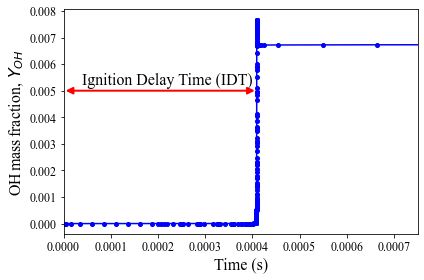

In [20]:
plt.figure()
plt.plot(timeHistory.index, timeHistory['oh'],'-o',color='b',markersize=4)
plt.xlabel('Time (s)',fontname='Times New Roman')
plt.ylabel('$\mathdefault{OH\, mass\, fraction,}\,  Y_{OH}}$',fontname='Times New Roman')

# Figure formatting:
plt.xlim([0,0.00075])
ax = plt.gca()
font = plt.matplotlib.font_manager.FontProperties(family='Times New Roman',size=14)
ax.annotate("",xy=(tau,0.005), xytext=(0,0.005),arrowprops=dict(arrowstyle="<|-|>",color='r',linewidth=2.0),fontsize=14,)
plt.annotate('Ignition Delay Time (IDT)', xy=(0,0), xytext=(0.00004, 0.00525), family='Times New Roman',fontsize=16);

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontname('Times New Roman')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontname('Times New Roman')

## Illustration : NTC behavior
In the paper by Kogekar, et al., the reactor model is used to demonstrate the impacts of non-ideal behavior on IDTs in the **N**egative **T**emperature **C**oefficient region, where observed IDTs, counter to intuition, increase with increasing temperature.

### Define the temperatures for which we will run the simulations

In [21]:
# Make a list of all the temperatures we would like to run simulations at
T = [1800, 1600, 1400, 1200, 1100, 1075, 1050, 1025, 1000, 975, 950, 925, 900, 850, 825, 800,
     750, 700]

estimatedIgnitionDelayTimes = np.ones(len(T))

# Set the initial guesses to a common value.  We could probably speed up simulations 
# by tuning this guess, but as seen in the figure above, the 'extra' time after igntion 
# does not add many data points or simulation steps.  The time savings would be small.
estimatedIgnitionDelayTimes[:] = 0.005

# Now create a dataFrame out of these
ignitionDelays = pd.DataFrame(data={'T':T})
ignitionDelays['ignDelay'] = np.nan

Run the code above for each temperature, and save the IDT for each.

In [22]:
for i, temperature in enumerate(T):
    # Set up the gas and reactor
    reactorTemperature = temperature
    reactorPressure = 40.0*101325.0
    gas.TP = reactorTemperature, reactorPressure
    gas.set_equivalence_ratio(phi=1.0, fuel='c12h26', oxidizer={'o2':1.0, 'n2':3.76})
    r = ct.Reactor(contents=gas)
    reactorNetwork = ct.ReactorNet([r])

    # Create an empty data frame
    timeHistory = pd.DataFrame(columns=timeHistory.columns)

    t0 = time.time()

    t = 0
    counter = 0
    while t < estimatedIgnitionDelayTimes[i]:
        t = reactorNetwork.step()
        if not counter % 20:
            timeHistory.loc[t] = r.get_state()
        counter += 1

    tau = ignitionDelay(timeHistory, 'oh')
    t1 = time.time()

    print('Computed Ignition Delay: {:.3e} seconds for T={}K. Took {:3.2f}s to compute'.format(tau, temperature, t1-t0))

    ignitionDelays.at[i, 'ignDelay'] = tau

Computed Ignition Delay: 6.378e-07 seconds for T=1800K. Took 3.86s to compute
Computed Ignition Delay: 1.583e-06 seconds for T=1600K. Took 3.99s to compute
Computed Ignition Delay: 5.791e-06 seconds for T=1400K. Took 4.52s to compute
Computed Ignition Delay: 3.911e-05 seconds for T=1200K. Took 5.69s to compute
Computed Ignition Delay: 1.326e-04 seconds for T=1100K. Took 5.82s to compute
Computed Ignition Delay: 1.839e-04 seconds for T=1075K. Took 5.97s to compute
Computed Ignition Delay: 2.533e-04 seconds for T=1050K. Took 6.42s to compute
Computed Ignition Delay: 3.365e-04 seconds for T=1025K. Took 6.37s to compute
Computed Ignition Delay: 4.093e-04 seconds for T=1000K. Took 6.84s to compute
Computed Ignition Delay: 4.289e-04 seconds for T=975K. Took 6.58s to compute
Computed Ignition Delay: 3.911e-04 seconds for T=950K. Took 6.96s to compute
Computed Ignition Delay: 3.407e-04 seconds for T=925K. Took 6.73s to compute
Computed Ignition Delay: 3.146e-04 seconds for T=900K. Took 7.05s t

### Figure: ignition delay ($\tau$) vs. the inverse of temperature ($\frac{1000}{T}$). 

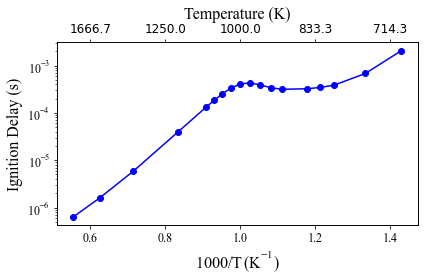

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(1000/ignitionDelays['T'], ignitionDelays['ignDelay'],'o-',color='b')
ax.set_ylabel('Ignition Delay (s)',fontname='Times New Roman',fontsize=16)
ax.set_xlabel(r'$\mathdefault{1000/T\, (K^{-1})}$', fontsize=16,fontname='Times New Roman')

# Add a second axis on top to plot the temperature for better readability
ax2 = ax.twiny()
ticks = ax.get_xticks()
ax2.set_xticks(ticks)
ax2.set_xticklabels((1000/ticks).round(1))
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel('Temperature (K)',fontname='Times New Roman',fontsize=16);

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontname('Times New Roman')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontname('Times New Roman')
for tick in ax2.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
    tick.label1.set_fontname('Times New Roman')

## Extension - looking at non-ideal impacts on NTC.

Using Cantera's object-oriented nature, and branching functions in Git, it is possible to explore the impacts of non-ideal effects on NTC behavior.  

As published in _Combust. Flame_ in 2017 (see above for reference), we created three different thermodynamic models to explore NTC of n-dodecane:

- 'Ideal gas': An ideal gas model.
- 'R-K $\left(\left[X_k\right]\right)$': A model which (incorrectly) used used the Redlich-Kwong model for the equation of state (EoS - phase density and species concentrations) but uses the ideal gas model for chemical kinetics (i.e. activity coefficients 
$\gamma_k = 1$ and $\dot{q} = k_{\rm fwd}\prod\left[X_k\right]^{\nu^\prime_k} - k_{\rm rev}\prod\left[X_k\right]^{\nu^{\prime\prime}_k}$).
- 'R-K $\left(\gamma_k\right)$':A model which (correctly) used the Redlich-Kwong model for both EoS and activity coefficient calculations, such that $\dot{q} = k_{\rm fwd}\prod\left(\gamma_k\left[X_k\right]\right)^{\nu^\prime_k} - k_{\rm rev}\prod\left(\gamma_k\left[X_k\right]\right)^{\nu^{\prime\prime}_k}$

### "Low" pressure (40 atm)
<img src="images/IDT_40atm.png"  width="500">

### Intermediate pressure (60 atm)
<img src="images/IDT_60atm_zoomed.png"  width="500">

### High pressure (80 atm)
<img src="images/IDT_80atm_zoomed.png"  width="500">

